### Introduction
This a test

#### 0) Simulation parameters

In [74]:
# Simulation general parameters
DAYS_TO_EXP     = 1 # days until expiration
N_SIMS          = 200 # number of simulations
REBAL_FREQ      = 1/252 # frequency of rebalancing
INI_PRICE       = 100 # stock initial price


# Simulation technical details
DRIFT           = 0.0 # stocks drift
ANNUALIZED_VOL  = 0.2 # process volatility
NDAYS_YEAR      = 252 # number of days per year


#### 00) Libraries

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm, lognorm

mpl.rcParams['figure.dpi']= 250

#### 000) Black-Scholes functions

In [76]:
# Define Black-Scholes functions
def calculate_call_delta(S, K, r, T, sigma):
    """
    Calculate the delta of an European call option using the Black-Scholes formula.

    Parameters:
    S (float): Current stock price.
    K (float): Strike price.
    r (float): Risk-free rate.
    T (float): Time to expiration (in years).
    sigma (float): Volatility.

    Returns:
    float: Delta of the call option.
    """
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

#### 1) Simulate the Brownian process

Some details:
- Returns will be simulated as lognormal. Let's say that the lognormal distribution of our process has mean $\mu$ and standard deviation $\sigma$. Then, the expected value of the random variable will be $e^{\mu + \sigma^2/2}$. It is important to realize that even if there is no drift, $\mu = 0$, the expected value will be afected by the variance, $e^{\sigma^2/2}$. Therefore, to simulate stock paths with zero drift it is necessary to substract $\sigma^2/2$ from the random variable. If not, the stock prices path will be drift.
- Test2

               Path1       Path2       Path3       Path4       Path5  \
1.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
0.996032  101.907384   97.326711   97.330483  100.095975  101.399947   
0.992063  100.641846   96.872183   97.899449   99.455275   98.939000   
0.988095  100.837830   97.881055   95.733818   98.121481   98.685792   
0.984127   99.294543   96.837177   95.647235   96.996034   99.423378   
...              ...         ...         ...         ...         ...   
0.019841  136.383116  119.353342   92.059348  113.525780   85.142458   
0.015873  134.142751  117.697960   90.859380  112.992133   86.283158   
0.011905  134.995287  117.282887   90.622486  114.684375   87.637049   
0.007937  133.140678  119.333862   90.427316  114.100712   87.508957   
0.003968  131.621553  117.798174   89.315961  113.449955   86.307608   

               Path6       Path7       Path8       Path9      Path10  ...  \
1.000000  100.000000  100.000000  100.000000  100.000000  

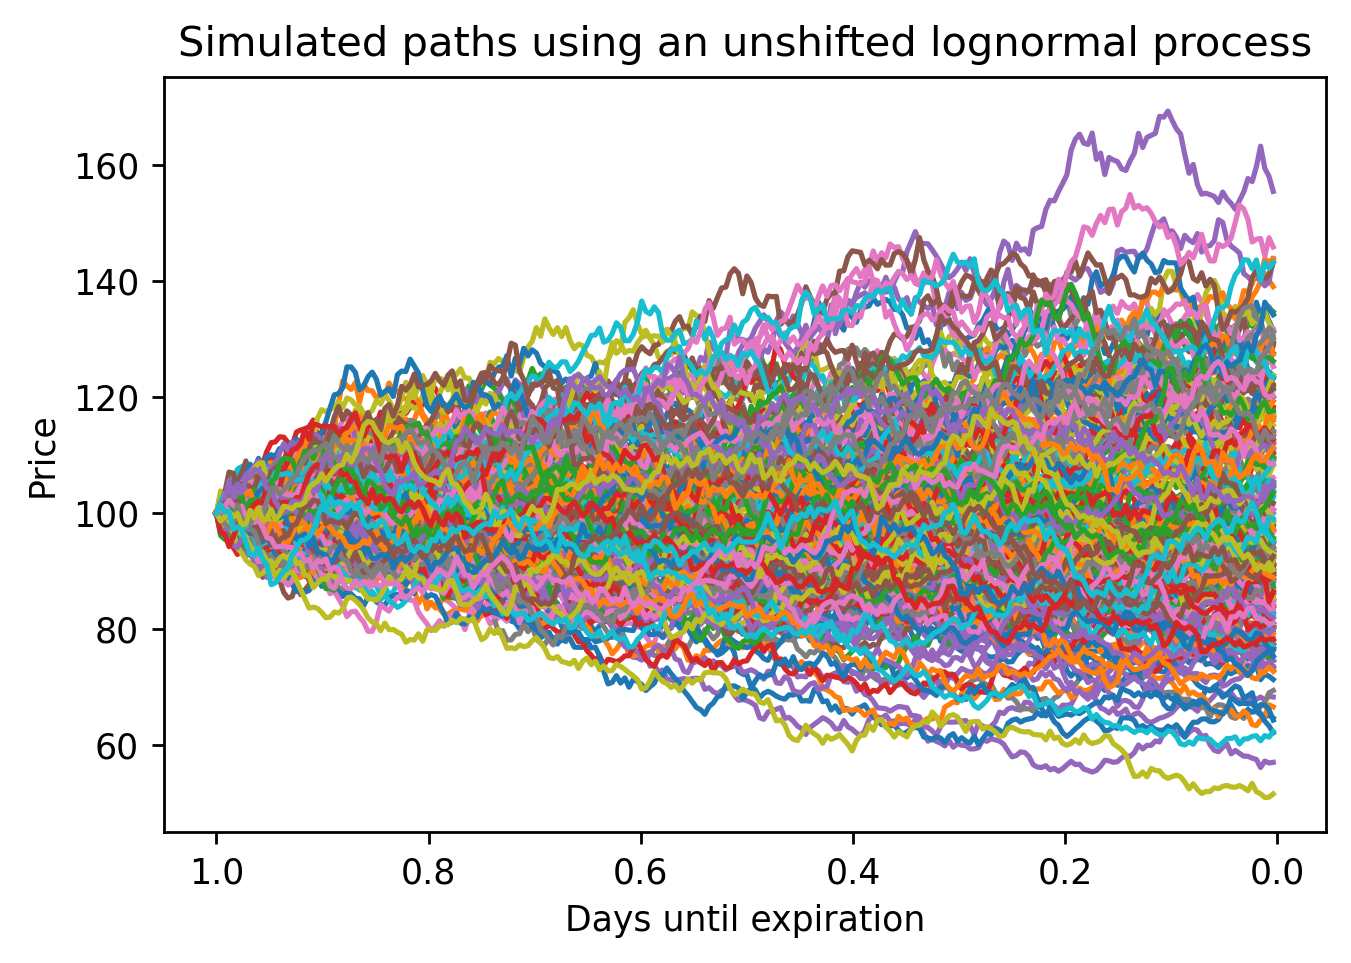

In [77]:
# Step volatility
daily_vol = ANNUALIZED_VOL*np.sqrt(REBAL_FREQ)

# Create a log-normal distribution object (sigma^2/2 is substracted from the mean)
lognorm_dist = lognorm(s = daily_vol, 
                       scale = np.exp(DRIFT - 0.5*(daily_vol)**2))

# Dataframe containing simulated paths
dfPaths = pd.DataFrame(np.nan, 
                       index = np.arange(start = DAYS_TO_EXP, stop = 0.0, step = -REBAL_FREQ), 
                       columns = [f'Path{i}' for i in range(1, N_SIMS+1)])

# Simulate each path
for column in dfPaths:
    for idx, step in enumerate(dfPaths[column]):

        if idx == 0:
            dfPaths[column].iloc[0] = INI_PRICE
        else:
            dfPaths[column].iloc[idx] = dfPaths[column].iloc[idx-1]*lognorm_dist.ppf(np.random.rand())

# Plot the stock paths
dfPaths.plot(legend = False)
plt.gca().invert_xaxis()
plt.xlabel('Days until expiration')
plt.ylabel('Price')
plt.title('Simulated paths using an unshifted lognormal process')

print(dfPaths)

#### 2) Compute the call option delta and the hedging PnL

The call option that I will simulate has an strike equal to 100. The interest rate will be assumed to be zero.

In [78]:
# Dataframe containing call delta
dfDelta = pd.DataFrame(np.nan, 
                       index = np.arange(start = DAYS_TO_EXP, stop = 0.0, step = -REBAL_FREQ), 
                       columns = [f'Delta for path{i}' for i in range(1, N_SIMS+1)])

# Dataframe containing hedging PnL
dfHedgingPnL = pd.DataFrame(np.nan, 
                            index = np.arange(start = DAYS_TO_EXP, stop = 0.0, step = -REBAL_FREQ), 
                            columns = [f'Hedging PnL for path{i}' for i in range(1, N_SIMS+1)])

# Go across each path and compute delta and hedging PnL
for idx_path in range(N_SIMS):
    for idx_step in range(dfPaths.shape[0]):

        dfDelta.iloc[idx_step, idx_path] = calculate_call_delta(dfPaths.iloc[idx_step, idx_path], 
                                                                100, 
                                                                0.0, 
                                                                dfPaths.index[idx_step], 
                                                                ANNUALIZED_VOL)
        
        if idx_step != 0:
            dfHedgingPnL.iloc[idx_step, idx_path] = -dfDelta.iloc[idx_step-1, idx_path]*\
                                                    (dfPaths.iloc[idx_step, idx_path] -\
                                                     dfPaths.iloc[idx_step-1, idx_path])
        
print(dfDelta)
print(dfHedgingPnL)


          Delta for path1  Delta for path2  Delta for path3  Delta for path4  \
1.000000         0.539828         0.539828     5.398278e-01         0.539828   
0.996032         0.577092         0.485660     4.857378e-01         0.541656   
0.992063         0.552397         0.476109     4.972203e-01         0.528772   
0.988095         0.556211         0.496678     4.522815e-01         0.501601   
0.984127         0.525324         0.474969     4.502217e-01         0.478260   
...                   ...              ...              ...              ...   
0.019841         1.000000         1.000000     1.734626e-03         0.999997   
0.015873         1.000000         1.000000     7.483580e-05         0.999999   
0.011905         1.000000         1.000000     3.374555e-06         1.000000   
0.007937         1.000000         1.000000     8.572528e-09         1.000000   
0.003968         1.000000         1.000000     1.594174e-19         1.000000   

          Delta for path5  Delta for pa